In [628]:
# %run common_imports.py

%matplotlib qt
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")

%reload_ext autoreload
%autoreload 2
pd.options.display.max_rows = 600
pd.set_option('display.float_format', lambda x: '%.9f' % x)

dj.config['display.limit'] = 10**3  

os.environ["SPYGLASS_USE_TRANSACTIONS"] = "1"  
os.environ['KACHERY_API_KEY'] = "RhysjLwgmBAt2ObCyXXaDnqAv2kTdYRa"

import sys
import tuning_analysis.sorting_multiprocessing as smp
import spyglass.spikesorting.v1 as sgs
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from tuning_analysis.trial_extraction import *
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from tuning_analysis.spike_analysis import *

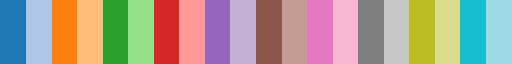

In [288]:
from cycler import cycler
cmap = 'tab20'
n_colors = 6
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0,1,n_colors)]
plt.rcParams["axes.prop_cycle"] = cycler(color = colors)
cmap

In [289]:
graph = sgpl.TrackGraph() & {"track_graph_name":"Wtrack_wilbur20210512"}

### Plot unit-wise spiking locations

#### Fetch spikes

In [5]:
sorter_keys = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "mountainsort4",
    "curation_id": 2,
}

pfc_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(sorter_keys, restrict_by_artifact = True)

keys = [{"merge_id": merge_id} for merge_id in pfc_merge_ids]
(SpikeSortingOutput.CurationV1 & keys)

[12:17:59][WARNING] Spyglass: V0 requires artifact restrict. Ignoring "restrict_by_artifact" flag.


merge_id,sorting_id,curation_id
047f4da5-c1d4-ca9e-f923-cdb63c0d04e7,d14d9669-4f3e-47c8-bed9-e0cc90be7a71,2
0a29f32c-7036-e6bb-fd45-dc7ac35137fe,45539c29-3436-4633-b63d-f499fe8e4073,2
1a818a97-6f62-8d75-565f-7be81c6961c3,ee34cd1e-e742-4c73-bdae-9974c2b1d74a,2
3b2a05fa-9642-5ef4-58d7-1f8e9bf3e217,76904362-d49e-4883-98d1-442822ebb9a1,2
4db00acd-003c-de9a-b640-fb78fb276985,df857aaa-ccd8-4abf-82e2-e9b97706c162,2
6e499686-18c3-ef61-e344-d4e7d7c5e773,bae249c1-f797-4e38-83ee-a21f51684a20,2
70ca787c-23b6-feb6-84af-6e3ba338fdf3,1dd1e911-c185-4488-b607-83502ac5225f,2
d4644925-b88e-850f-36a2-291d1e1b99f7,48a2c037-f872-4a63-9ccb-1bd14cb727e4,2
e7eb99a4-da0e-a1ca-3be6-36e6037f9275,6868b312-14db-473b-ae34-ce1bd193055d,2
e9df24a9-9413-0623-2987-3064c50394ed,0c0d6f10-5af6-4add-beac-67f101ecb017,2


In [6]:
# get spikes from a specific group
group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "left mPFC",
}

SortedSpikesGroup().Units & group_key
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")

l_mpfc_spikes = SortedSpikesGroup().fetch_spike_data(group_key)


#### Fetch position

In [ ]:
epoch = 2
dlc_centroid_params_name = "four_paw_centroid"
pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "epoch": f"{epoch}", 
    "dlc_model_params_name": "WtrackSep5",
    "dlc_centroid_params_name": dlc_centroid_params_name  
}

merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

#### Plot

In [8]:
centroid_position = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()

In [107]:
# Single unit firing across all positions
unit = 4
spike_times = l_mpfc_spikes[unit]
spike_times = spike_times
spike_times = pd.Series([spike_time if spike_time < centroid_position.index[-1] else np.nan for spike_time in spike_times]).dropna().to_list()
spike_positions = np.searchsorted(centroid_position.index.tolist(), spike_times)
fig,ax = plt.subplots(layout = "tight")
ax.scatter(centroid_position.position_x, centroid_position.position_y, s = 4, color = 'k', alpha = 0.03)
ax.scatter(centroid_position.position_x.iloc[spike_positions], centroid_position.position_y.iloc[spike_positions], color = "#1188d8", s = 4, label = "spikes")
plt.legend();

### Extract trials

In [597]:
def get_centroid_and_linear_position(epoch: int,
                                     dlc_si_cohort_centroid: str = "nose_tail_no_nan",
                                     linearization_param_name: str = "default"):
    merge_id = (PositionOutput.DLCPosV1() & {"epoch": epoch, "dlc_si_cohort_centroid": dlc_si_cohort_centroid}).fetch1("merge_id")
    centroid_df = (PositionOutput & {"merge_id": merge_id}).fetch1_dataframe()
    
    pos_merge_id = (PositionOutput.DLCPosV1() & {"dlc_si_cohort_centroid": dlc_si_cohort_centroid, "epoch": epoch}).fetch1("merge_id")
    linear_df =(sgpl.LinearizedPositionV1() & {"pos_merge_id":pos_merge_id, "linearization_param_name": linearization_param_name}).fetch1_dataframe()
    
    return centroid_df, linear_df

In [598]:
epoch2_centroid_df, epoch2_linear_df = get_centroid_and_linear_position(epoch=2, dlc_si_cohort_centroid= "four_paw_centroid")
epoch4_centroid_df, epoch4_linear_df = get_centroid_and_linear_position(epoch=4, dlc_si_cohort_centroid= "four_paw_centroid")
epoch6_centroid_df, epoch6_linear_df = get_centroid_and_linear_position(epoch=6, dlc_si_cohort_centroid= "four_paw_centroid")
epoch8_centroid_df, epoch8_linear_df = get_centroid_and_linear_position(epoch=8, dlc_si_cohort_centroid= "four_paw_centroid")


In [599]:
#get lick evenets and trial events
lick_events_df = prepare_DIO_data(session_restriction=session_restrict, lick_event_threshold=2)
trials_df = prepare_trial_data(lick_events_df)

IndexError: list index out of range

In [600]:
#merge position information with all trials
target = pd.concat([epoch2_centroid_df, epoch2_linear_df], axis = 1)
e2_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch4_centroid_df, epoch4_linear_df], axis = 1)
e4_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch6_centroid_df, epoch6_linear_df], axis = 1)
e6_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch8_centroid_df, epoch8_linear_df], axis = 1)
e8_trialized_position = merge_trial_df_with_target(target, trials_df)



In [601]:
trialized_position = pd.concat([e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position], axis = 0)
trialized_position.head()

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed,linear_position,track_segment_id,projected_x_position,...,trial_start,trial_end,trial_duration (s),trial_label,trial_type,"trial_direction (previous, current, next)",left/right,trial_progress,trial_progress_distance,zone
time,,,,,,,,,,,,,,,,,,,,,
1620843475.612429380,83.000000000,127.504175481,65.046794271,0.099815431,16.875811765,-0.712380772,16.890840982,265.000000000,2,100.000000000,...,1620843475.599593878,1620843506.746830702,31.147236824,error,NA,"(middle, left)",NaN,0.000412091,0.000000000,run
1620843475.627006292,84.000000000,127.816128326,64.969273707,0.114003507,15.875402300,-0.833293062,15.897256855,265.000000000,2,100.000000000,...,1620843475.599593878,1620843506.746830702,31.147236824,error,NA,"(middle, left)",NaN,0.000880091,0.000000000,run
1620843475.641583204,85.000000000,128.048211370,64.845094635,0.120714767,14.680507831,-0.937965530,14.710441513,265.000000000,2,100.000000000,...,1620843475.599593878,1620843506.746830702,31.147236824,error,NA,"(middle, left)",NaN,0.001348092,0.000000000,run
1620843475.656160116,86.000000000,128.099017802,64.788368423,0.123236630,13.346479260,-1.025877845,13.385848273,265.000000000,2,100.000000000,...,1620843475.599593878,1620843506.746830702,31.147236824,error,NA,"(middle, left)",NaN,0.001816092,0.000000000,run
1620843475.670737267,87.000000000,128.118677780,64.762642174,0.120297007,11.933152343,-1.096506826,11.983424054,265.000000000,2,100.000000000,...,1620843475.599593878,1620843506.746830702,31.147236824,error,NA,"(middle, left)",NaN,0.002284100,0.000000000,run


In [ ]:
# Plot trajectory for a single trial
trial = 12

t_start = trials_df.loc[trials_df["trial_number"] == trial, "trial_start"].iloc[0]
t_end = trials_df.loc[trials_df["trial_number"] == trial, "trial_end"].iloc[0]

# build boolean mask and select rows between the timestamps
mask = (l_centroid_df.index > t_start) & (l_centroid_df.index < t_end)
fig, ax = plt.subplots(layout = 'tight')
plot_background_position(l_centroid_df, ax)
l_centroid_df.loc[mask].plot.scatter(x = "position_x", y = "position_y", s = 8, ax = ax, c = l_centroid_df.loc[mask].index, cmap = "Blues")

<Axes: xlabel='position_x', ylabel='position_y'>

In [301]:
#plot various phases of a task
trial = 100

mask_reward = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "reward")
mask_run = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "run")
mask_turn = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "turn")

fig, ax = plt.subplots(figsize = (15, 12), layout = "tight")
plot_background_position( trialized_position, ax)
trialized_position[mask_reward].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "green")
trialized_position[mask_turn].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "yellow")
trialized_position[mask_run].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "red");

In [302]:
fig, ax = plt.subplots()
graph.plot_track_graph_as_1D(draw_edge_labels=True, ax = ax)
fig, ax = plt.subplots()
graph.plot_track_graph(draw_edge_labels=True, ax= ax)

### Behavior

In [ ]:
#Incorrect trial numbers
pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"])

In [ ]:
#plot single trial trajectory and speed 
trial = 18
mask = trialized_position["trial_number"]==trial
timestamps = trialized_position[mask].index - trialized_position[mask].index.tolist()[0]
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, 2, layout = "tight", figsize = (20, 10))
    plot_background_position(trialized_position, ax[0], background_color="white")
    trialized_position[mask].plot.scatter(x = "position_x", y = "position_y", ax = ax[0], c = "speed", s = 20, vmin = 0, vmax = 80)
    ax[1].plot(timestamps, trialized_position[mask]["speed"])

### Spingle unit spikes/behavior tuning

In [303]:
def fetch_single_epoch_spikes(nwb_file_name: str,
                              sorted_spikes_group_nane: str):
    group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": sorted_spikes_group_nane
    }
    
    SortedSpikesGroup.Units & group_key
    
    group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
    return SortedSpikesGroup().fetch_spike_data(group_key)

In [375]:
l_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="left mPFC")


In [376]:
mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="mPFC")

#### Speed tuning

In [378]:
#rest vs run
mean_fr_df = rest_vs_run_firing_rates(l_mpfc_spikes, trialized_position[(trialized_position["track_segment_id"]==2)]
                                      , speed_threshold=5, segment_threshold=3)
plot_rest_vs_run_fr(mean_fr_df)


In [ ]:
df = e8_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


# speed_tuning, speed_bin_centers = compute_tuning(
#      df,  
#     "speed",
#     spikes_list,
#     n_bins=8,
#     mask=mask,
# )


# plot_tuning_grid(speed_tuning, "speed",  df, spikes_list, mask, n_units = 40, label = f"({zone}; {trial_types})")
# plot_position_tuning_grid(position_tuning,  df, spikes_list, mask, n_units = -1, label = f"entire epoch")

# bootstrap across trials
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "speed",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed", n_units=30, 
    indices = speed_bell_unit_ids,
    label = "epoch 8"
)


In [308]:
#plot single unit spikes: rest vs run
unit = 2

mask_stat = trialized_position["speed"]<5
mask_running = trialized_position["speed"]>5


spike_idx = np.searchsorted(trialized_position.index.tolist(), spikes_list[unit][spikes_list[unit]>trialized_position.index[0]])
spike_idx_stat = np.searchsorted(trialized_position[mask_stat].index.tolist(), spikes_list[unit])
spike_idx_running = np.searchsorted(trialized_position[mask_running].index.tolist(), spikes_list[unit])
fig, ax = plt.subplots(layout = "tight")
plot_background_position(trialized_position, ax)
ax.scatter(trialized_position.position_x.iloc[spike_idx_stat], trialized_position.position_y.iloc[spike_idx_stat], s = 10, color = "y", label = "speed < 3 cm/s")
ax.scatter(trialized_position.position_x.iloc[spike_idx_running], trialized_position.position_y.iloc[spike_idx_running], s = 10, color = "r", label = "speed > 3 cm/s")
plt.legend()

270

#### Direction tuning

In [309]:
# Positional restriction: only track_segment_id == 2

#OUTBOUND VS INBOUND 
pos_df = trialized_position[(trialized_position["zone"] == "run")].copy()
arms = [2]
last_trial = 1e6

pos_mask_outin = (pos_df["track_segment_id"].isin(arms))

summary_outin , trial_outin  = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df=trials_df[trials_df["trial_number"] < last_trial],  
    position_df=pos_df,
    pos_mask=pos_mask_outin,
    category_col="trial_type",       
    category_a="inbound",
    category_b="outbound",
    only_correct=True,
    min_duration=0.5,              
)

mw_outin  = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_outin ,
    category_a="inbound",
    category_b="outbound",
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided"
)
plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_outin ,
    category_a="inbound",
    category_b="outbound",
    use_sem=True,
    title = f"Trialwise firing rate; inbound vs outbound",
    stats_df = mw_outin ,
    alpha = 0.05
)

display(mw_outin [mw_outin ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_outin [mw_outin ["p_value"]<0.05]))


,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,77,75,9.244446606,18.547881245,946.000000000,0.000000000,outbound
2,2,77,75,0.665399355,1.504843338,1913.500000000,0.000181030,outbound
3,3,77,75,3.029891164,11.525432241,533.000000000,0.000000000,outbound
5,5,77,75,1.625277785,3.935882401,1282.500000000,0.000000003,outbound
6,6,77,75,2.541099277,8.106321308,1378.500000000,0.000000023,outbound
7,7,77,75,1.025141720,0.070558737,3718.000000000,0.000187093,inbound
8,8,77,75,1.834443724,17.118031428,322.000000000,0.000000000,outbound
9,9,77,75,8.852478267,1.293452657,5249.500000000,0.000000000,inbound
10,10,77,75,0.053814458,0.385097290,1521.000000000,0.000000002,outbound
11,11,77,75,3.602391020,1.239719641,4526.000000000,0.000000001,inbound


Number of siginificant units:  141


In [310]:

#INBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "inbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 1e6

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_in_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_in_lr  , trial_in_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_in_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_in_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_in_lr  ,
    alpha = 0.05
)



display(mw_in_lr  [mw_in_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_in_lr  [mw_in_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,37,39,6.504200030,11.836278489,404.000000000,0.000984715,right
2,2,37,39,0.390065958,0.943674613,489.000000000,0.005794653,right
5,5,37,39,2.329584035,0.998763594,952.500000000,0.014245659,left
8,8,37,39,1.159130947,2.522162095,522.500000000,0.031997487,right
10,10,37,39,0.019516824,0.087733098,613.000000000,0.035114783,right
13,13,37,39,6.281533939,4.000767472,1073.500000000,0.000257086,left
17,17,37,39,7.823787372,3.514628581,923.000000000,0.032575544,left
21,21,37,39,12.115213958,20.984472114,455.000000000,0.005702233,right
22,22,37,39,16.696540839,13.789194120,959.500000000,0.013579163,left
31,31,37,39,0.100221528,0.235953842,614.000000000,0.036840911,right


Number of siginificant units:  54


In [311]:

#OUTBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "outbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_out_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_out_lr  , trial_out_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_out_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_out_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_out_lr  ,
    alpha = 0.05
)



display(mw_out_lr  [mw_out_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_out_lr  [mw_out_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
4,4,7,6,3.190661850,1.317392717,36.000000000,0.034965035,left
14,14,7,6,0.307469510,1.722950128,6.000000000,0.037259910,right
60,60,7,6,5.039529103,2.914450558,38.000000000,0.013986014,left
65,65,7,6,4.580074547,7.302256513,6.000000000,0.034965035,right
96,96,7,6,3.940864000,1.633734611,36.000000000,0.034965035,left
120,120,7,6,4.147895122,2.113276372,36.000000000,0.034965035,left
153,153,7,6,0.005177091,0.154342819,4.000000000,0.010392624,right
170,170,7,6,1.072074062,1.935261989,4.000000000,0.013986014,right


Number of siginificant units:  8


#### Location tuning

In [313]:
# do speeds cluster at certain locations?

zones = ["run"]
trial_types = ["inbound"]  

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

speed_col = "speed"
n_bins = 8

# Work only on the masked rows for binning
speed_vals = trialized_position.loc[mask, speed_col].astype(float)
speed_vals = speed_vals.replace([np.inf, -np.inf], np.nan).dropna()

# Guard: nothing to bin
if speed_vals.empty:
    raise ValueError("No finite speed values after applying mask; cannot bin/plot.")

bin_edges = np.linspace(speed_vals.min(), speed_vals.max(), n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins for masked rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_vals.index, "speed_bin"] = pd.cut(
    speed_vals,
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

binned_position_idx = [
    trialized_position.index[mask & (trialized_position["speed_bin"] == i)]
    for i in range(n_bins)
]

# arrange on different axes in a 2-column grid
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    layout="tight",
    figsize=(12, 3 * n_rows),
    sharex=True, sharey=True,
)

axes = np.array(axes).reshape(-1)
cmap = plt.get_cmap("viridis", n_bins)

# background once-per-axis, but use masked background (faster + consistent)
background_df = trialized_position.loc[mask]

for i, index in enumerate(binned_position_idx):
    ax_i = axes[i]
    color = cmap(i)

    # background: all positions within mask
    background_df.plot.scatter(
        x="position_x", y="position_y",
        s=4, ax=ax_i, color="k", alpha=0.02,
    )

    # highlighted: this speed bin (already within mask by construction)
    df_bin = trialized_position.loc[index]
    df_bin.plot.scatter(
        x="position_x", y="position_y",
        s=8, ax=ax_i, color=color,
        label=int(speed_bin_centers[i]),
        alpha=0.8,
    )

    ax_i.set_title(f"bin {i} (center {int(speed_bin_centers[i])})")
    ax_i.set_xlabel("x position (cm)")
    ax_i.set_ylabel("y position (cm)")

# hide any unused axes
for j in range(n_bins, len(axes)):
    axes[j].axis("off")

plt.show()


In [355]:

spikes_list = l_mpfc_spikes.copy()
zone = "run"
trial_type = "outbound"
mask = (trialized_position["trial_type"] == f"{trial_type}") \
          #  & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "linear_position",
    spikes_list,
    n_bins=8,
    mask=mask,
)

# plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "linear_position", trialized_position, spikes_list, None, n_units = 33, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")


#### Progress tuning

In [607]:
df = e8_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


#  progress_tuning,  progress_bin_centers = compute_tuning(
#      df,  
#     " progress",
#     spikes_list,
#     n_bins=8,
#     mask=mask,
# )


# plot_tuning_grid( progress_tuning, " progress",  df, spikes_list, mask, n_units = 40, label = f"({zone}; {trial_types})")
# plot_position_tuning_grid(position_tuning,  df, spikes_list, mask, n_units = -1, label = f"entire epoch")

# bootstrap across trials
progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   # you have lots of trials; you can be strict
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress", n_units=30, 
    indices = None,
    label = "epoch 8"
)


In [ ]:
df = e8_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


#  progress_tuning,  progress_bin_centers = compute_tuning(
#      df,  
#     " progress",
#     spikes_list,
#     n_bins=8,
#     mask=mask,
# )


# plot_tuning_grid( progress_tuning, " progress",  df, spikes_list, mask, n_units = 40, label = f"({zone}; {trial_types})")
# plot_position_tuning_grid(position_tuning,  df, spikes_list, mask, n_units = -1, label = f"entire epoch")

# bootstrap across trials
progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress_distance",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200, 
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress_distance", n_units=30, 
    indices = speed_bell_unit_ids,
    label = "epoch 8"
)


In [590]:
trialized_position["trial_progress_distance"].describe()

count   187850.000000000
mean         0.154517340
std          0.379084933
min         -1.976269704
25%         -0.001972796
50%          0.000574487
75%          0.145457822
max          3.065017150
Name: trial_progress_distance, dtype: float64

In [569]:
print("Tuning shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               29         17
increasing         17         99
decreasing         71         30
U                  20         36
flat/complex      126         81


#### Speed vs progress


In [630]:
trial_types = ["inbound", "outbound"]
mask = (
    # (trialized_position["zone"].isin(zones))
    (trialized_position["trial_type"].isin(trial_types))
)
n_bins = 60
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress")
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress_distance")

#### Retrieve firing properties of each unit

In [372]:
l_mpfc_recording, l_mpfc_sorting = get_si_recording_and_sorting({"sorted_spikes_group_name": "left mPFC"})
mpfc_recording, mpfc_sorting =  get_si_recording_and_sorting({"sorted_spikes_group_name": "mPFC"})

[2025-12-26 18:03:34,768][WARNING]: Skipped checksum for file with hash: 4fe4d66a-3248-0b34-c4f8-15d475921734, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_AAB10XJKBQ.nwb
[2025-12-26 18:04:00,509][WARNING]: Skipped checksum for file with hash: 676121b3-a983-4d36-9931-85731ed52264, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_8U2V42ZXRX.nwb
[2025-12-26 18:04:25,979][WARNING]: Skipped checksum for file with hash: 080a0ccb-e708-9189-9d3b-1494584723d1, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_718I728WPW.nwb
[2025-12-26 18:04:52,304][WARNING]: Skipped checksum for file with hash: 2cc6b441-7ed5-0614-6be0-5dfa638d9225, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_819RJCTZU8.nwb
[2025-12-26 18:05:20,161][WARNING]: Skipped checksum for file with hash: ae416731-c7f6-96c4-58b5-f63c6137d5b2, and path: /media/labuser/

AssertionError: Locations are not unique! Cannot aggregate recordings!

In [ ]:
waveform_folder = "/media/labuser/NA_1_2025/spyglass/J16/analysis/waveforms_epoch2_mpfc"

l_mpfc_we = si.extract_waveforms(
    mpfc_recording,
    mpfc_sorting,
    folder=waveform_folder,
    load_if_exists=True,         
    overwrite=False,             
    max_spikes_per_unit=300,     
    ms_before=1.0,               
    ms_after=2.0,                
    n_jobs= 12,                    
    chunk_duration="1s",         
    progress_bar=True,
)


/tmp/ipykernel_1058769/2147982319.py:3: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  l_mpfc_we = si.extract_waveforms(


In [ ]:
run_mask = (trialized_position["zone"] == "run") #& (trialized_position["trial_type"]=="inbound")
outbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="outbound")
inbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="inbound") 

mpfc_sorting_run = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=run_mask,
)



mpfc_sorting_outbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=outbound_mask,
)

mpfc_sorting_inbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=inbound_mask,
)



In [327]:
trial_type = "inbound"


if trial_type == "inbound":
    sorting = l_mpfc_sorting_inbound
elif trial_type == "outbound":
    sorting = l_mpfc_sorting_outbound

plot_unit_speed_acg_template_grid(
    # unit_ids=[2, 8, 13, 16, 17, 18, 32, 28], # the "interesting" units
    unit_ids = [23, 8], # left vs right tuned on the inboud trials
    spikes_list=l_mpfc_spikes,
    speed_tuning=speed_tuning,
    speed_bin_centers=speed_bin_centers,
    sorting=sorting,               
    waveform_extractor=l_mpfc_we,
    position_df=trialized_position[(trialized_position["trial_type"]==trial_type)],     
    mask=None,
    plot_speed=True,
    plot_acg=True,
    plot_template=True,
    bin_ms=20.0,
    window_ms=1000.0,
    suptitle = ""
)


(<Figure size 900x440 with 6 Axes>,
 array([[<Axes: ylabel='unit 23 (1.40 Hz)'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Speed (cm/s)', ylabel='unit 8 (2.80 Hz)'>,
         <Axes: xlabel='Lag (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

#### Figurl

In [632]:
df = trialized_position
# speed (bootstrap)
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot_s, curvature_boot_s = compute_tuning_bootstrap_trials(
    df, "speed", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
speed_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_s, curvature_boot_s, ci=0.95, min_valid_boot=200)

# progress (bootstrap)
progress_tuning, progress_centers, progress_lower, progress_upper, slope_boot_p, curvature_boot_p = compute_tuning_bootstrap_trials(
    df, "trial_progress", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
progress_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_p, curvature_boot_p, ci=0.95, min_valid_boot=200)

# location (non-bootstrap example)
location_tuning, location_centers = compute_tuning(
    trialized_position, "trial_progress_distance", spikes_list, n_bins=8, mask=mask
)


In [636]:
unit_ids = select_units_by_shape(speed_shape_by_unit, include_shapes=["decreasing"])
# unit_ids = unit_ids[:30]
